In [ ]:
!git clone https://github.com/him4318/Transformer-ocr.git

Cloning into 'Transformer-ocr'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 74 (delta 28), reused 42 (delta 10), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [ ]:
%cd Transformer-ocr/

/content/Transformer-ocr


In [ ]:
!pip install -r requirements.txt

In [ ]:
%cd src/

/content/Transformer-ocr/src


### 1.3 HDF5 files

Now, you'll run the *transform* function from **main.py**. For this, execute on **src** folder:

> ```python main.py --source=<DATASET_NAME> --transform```

Your data will be preprocess and encode, creating and saving in the **data** folder. Now your project directory will be like this:


```
.
├── data
│   ├── bentham.hdf5
│   ├── iam.hdf5
│   ├── rimes.hdf5
│   ├── saintgall.hdf5
│   └── washington.hdf5
├── raw
│   ├── bentham
│   │   ├── BenthamDatasetR0-GT
│   │   └── BenthamDatasetR0-Images
│   ├── iam
│   │   ├── ascii
│   │   ├── forms
│   │   ├── largeWriterIndependentTextLineRecognitionTask
│   │   ├── lines
│   │   └── xml
│   ├── rimes
│   │   ├── eval_2011
│   │   ├── eval_2011_annotated.xml
│   │   ├── training_2011
│   │   └── training_2011.xml
│   ├── saintgall
│   │   ├── data
│   │   ├── ground_truth
│   │   ├── README.txt
│   │   └── sets
│   └── washington
│       ├── data
│       ├── ground_truth
│       ├── README.txt
│       └── sets
└── src
    ├── data
    │   ├── evaluation.py
    │   ├── generator.py
    │   ├── preproc.py
    │   ├── reader.py
    ├── main.py
    ├── engine.py
    ├── network
    │   ├── model.py
    └── tutorial.ipynb

```

Then upload the **data** and **src** folders in the same directory in your Google Drive.

In [ ]:
from pathlib import Path
import numpy as np
import math
from itertools import groupby
import h5py
import numpy as np
import unicodedata
import cv2
import torch
from torch import nn
from torchvision.models import resnet50, resnet101
from torch.autograd import Variable
import torchvision
from data import preproc as pp
from data import evaluation
from torch.utils.data import Dataset
import time

In [ ]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=128):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class OCR(nn.Module):

    def __init__(self, vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers):
        super().__init__()

        # create ResNet-101 backbone
        self.backbone = resnet101()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads with length of vocab
        # DETR used basic 3 layer MLP for output
        self.vocab = nn.Linear(hidden_dim,vocab_len)

        # output positional encodings (object queries)
        self.decoder = nn.Embedding(vocab_len, hidden_dim)
        self.query_pos = PositionalEncoding(hidden_dim, .2)

        # spatial positional encodings, sine positional encoding can be used.
        # Detr baseline uses sine positional encoding.
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.trg_mask = None
  
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask==1, float('-inf'))
        return mask

    def get_feature(self,x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)   
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        return x


    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)


    def forward(self, inputs, trg):
        # propagate inputs through ResNet-101 up to avg-pool layer
        x = self.get_feature(inputs)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        bs,_,H, W = h.shape
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # generating subsequent mask for target
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(trg.shape[1]).to(trg.device)

        # Padding mask
        trg_pad_mask = self.make_len_mask(trg)

        # Getting postional encoding for target
        trg = self.decoder(trg)
        trg = self.query_pos(trg)
        
        output = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1), trg.permute(1,0,2), tgt_mask=self.trg_mask, 
                                  tgt_key_padding_mask=trg_pad_mask.permute(1,0))

        return self.vocab(output.transpose(0,1))


def make_model(vocab_len, hidden_dim=256, nheads=4,
                 num_encoder_layers=4, num_decoder_layers=4):
    
    return OCR(vocab_len, hidden_dim, nheads,
                 num_encoder_layers, num_decoder_layers)

In [ ]:
"""
Uses generator functions to supply train/test with data.
Image renderings and text are created on the fly each time.
"""

class DataGenerator(Dataset):
    """Generator class with data streaming"""

    def __init__(self, source,charset, max_text_length, split, transform):
        self.tokenizer = Tokenizer(charset, max_text_length)
        self.transform = transform
        
        self.split = split
        self.dataset = dict()

        with h5py.File(source, "r") as f:
            self.dataset[self.split] = dict()

            self.dataset[self.split]['dt'] = np.array(f[self.split]['dt'])
            self.dataset[self.split]['gt'] = np.array(f[self.split]['gt'])
          
            randomize = np.arange(len(self.dataset[self.split]['gt']))
            np.random.seed(42)
            np.random.shuffle(randomize)

            self.dataset[self.split]['dt'] = self.dataset[self.split]['dt'][randomize]
            self.dataset[self.split]['gt'] = self.dataset[self.split]['gt'][randomize]

            # decode sentences from byte
            self.dataset[self.split]['gt'] = [x.decode() for x in self.dataset[self.split]['gt']]
            
        self.size = len(self.dataset[self.split]['gt'])


    def __getitem__(self, i):
        img = self.dataset[self.split]['dt'][i]
        
        #making image compatible with resnet
        img = np.repeat(img[..., np.newaxis],3, -1)    
        img = pp.normalization(img)
        
        if self.transform is not None:
            img = self.transform(img)

        y_train = self.tokenizer.encode(self.dataset[self.split]['gt'][i]) 
        
        #padding till max length
        y_train = np.pad(y_train, (0, self.tokenizer.maxlen - len(y_train)))

        gt = torch.Tensor(y_train)

        return img, gt          

    def __len__(self):
      return self.size



class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK,self.SOS,self.EOS = "¶", "¤", "SOS", "EOS"
        self.chars = [self.PAD_TK] + [self.UNK_TK ]+ [self.SOS] + [self.EOS] +list(chars)
        self.PAD = self.chars.index(self.PAD_TK)
        self.UNK = self.chars.index(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""

        text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        text = ['SOS'] + list(text) + ['EOS']
        for item in text:
            index = self.chars.index(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""
        
        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = pp.text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")



In [ ]:
#bentham data set download link

#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr" -O bentham.hdf5 && rm -rf /tmp/cookies.txt


--2020-06-21 13:43:37--  https://docs.google.com/uc?export=download&confirm=tcWk&id=1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr
Resolving docs.google.com (docs.google.com)... 74.125.133.102, 74.125.133.101, 74.125.133.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.133.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-7g-docs.googleusercontent.com/docs/securesc/vuv21v5jgdj7k8mpv2ac4fiq1qcaveat/2grodk2ochcj6q1h2tkhfjg48qagggma/1592746950000/11488128581626754426/08796100045038332580Z/1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr?e=download [following]
--2020-06-21 13:43:37--  https://doc-08-7g-docs.googleusercontent.com/docs/securesc/vuv21v5jgdj7k8mpv2ac4fiq1qcaveat/2grodk2ochcj6q1h2tkhfjg48qagggma/1592746950000/11488128581626754426/08796100045038332580Z/1-PqlAml3vKzWknITlC3jaoFNu5rKyFbr?e=download
Resolving doc-08-7g-docs.googleusercontent.com (doc-08-7g-docs.googleusercontent.com)... 108.177.15.132, 2a00:1450:400c:c0c::84
Connecting

In [ ]:
import os
import datetime
import string

batch_size = 16
epochs = 200

# define paths
#change paths accordingly
source = 'bentham'
source_path = '/content/drive/{}.hdf5'.format(source)
output_path = os.path.join("..", "output", source)
target_path = os.path.join(output_path, "checkpoint_weights_iam.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: /content/drive/My Drive/handwriting/handwritten-text-recognition/data/bentham.hdf5
output ../output/bentham
target ../output/bentham/checkpoint_weights_iam.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [ ]:
import torchvision.transforms as T

device = torch.device("cuda")
transform = T.Compose([
    T.ToTensor()])
tokenizer = Tokenizer(charset_base)

train_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'train',transform), batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'valid',transform), batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
model = make_model(vocab_len=tokenizer.vocab_size)
_=model.to(device)

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx=0, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))


In [ ]:
criterion = LabelSmoothing(size=tokenizer.vocab_size, padding_idx=0, smoothing=0.1)
criterion.to(device)
lr = .0001 # learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=.0004)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
def train(model, criterion, optimiser, scheduler,dataloader):
 
    model.train()
    total_loss = 0
    for batch, (imgs, labels_y,) in enumerate(dataloader):
          imgs = imgs.to(device)
          labels_y = labels_y.to(device)
    
          optimiser.zero_grad()
          output = model(imgs.float(),labels_y.long()[:,:-1])
 
          norm = (labels_y != 0).sum()
          loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm
 
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
          optimizer.step()
          total_loss += loss.item() * norm
 
    return total_loss / len(dataloader)
 
def evaluate(model, criterion, dataloader,):
 
    model.eval()
    epoch_loss = 0
 
    with torch.no_grad():
      for batch, (imgs, labels_y,) in enumerate(dataloader):
            imgs = imgs.to(device)
            labels_y = labels_y.to(device)
 
            output = model(imgs.float(),labels_y.long()[:,:-1])
              
            norm = (labels_y != 0).sum()
            loss = criterion(output.log_softmax(-1).contiguous().view(-1, tokenizer.vocab_size), labels_y[:,1:].contiguous().view(-1).long()) / norm
  
            epoch_loss += loss.item() * norm
 
    return epoch_loss / len(dataloader)

In [ ]:
#train model
 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
 
best_valid_loss = np.inf
c = 0
for epoch in range(200):
 
    print(f'Epoch: {epoch+1:02}','learning rate{}'.format(scheduler.get_last_lr()))
    
    start_time = time.time()
 
    train_loss = train(model,  criterion, optimizer, scheduler, train_loader)
    valid_loss = evaluate(model, criterion, val_loader)
 
    epoch_mins, epoch_secs = epoch_time(start_time, time.time())
 
    c+=1
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), target_path)
        c=0
 
    if c>4:
        #decrease lr if loss does not deacrease after 5 steps
        scheduler.step()
        c=0
 
    print(f'Time: {epoch_mins}m {epoch_secs}s') 
    print(f'Train Loss: {train_loss:.3f}')
    print(f'Val   Loss: {valid_loss:.3f}')

You can download the trained model and run inference on it.
Below link downloads the model. Once model is downloaded you can move it to your google storage.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE" -O resnet_best.pt && rm -rf /tmp/cookies.txt


--2020-06-21 11:54:15--  https://docs.google.com/uc?export=download&confirm=WvBe&id=1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE
Resolving docs.google.com (docs.google.com)... 173.194.216.102, 173.194.216.113, 173.194.216.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-0g-docs.googleusercontent.com/docs/securesc/l2rn7lfpoqt3k39fmdq4jear5dpbn6fj/385vtu02oatlr5ji0jaaod8fupol8t9i/1592740425000/11488128581626754426/05090935087800176943Z/1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE?e=download [following]
--2020-06-21 11:54:15--  https://doc-0o-0g-docs.googleusercontent.com/docs/securesc/l2rn7lfpoqt3k39fmdq4jear5dpbn6fj/385vtu02oatlr5ji0jaaod8fupol8t9i/1592740425000/11488128581626754426/05090935087800176943Z/1rypn6NxxbYcBA8Nv2bv8lsyNe3AUSTCE?e=download
Resolving doc-0o-0g-docs.googleusercontent.com (doc-0o-0g-docs.googleusercontent.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connect

In [ ]:
#I trained my model with vocab length equal to 100
model = make_model(vocab_len=100)
_=model.to(device)

model.load_state_dict(torch.load('/content/Transformer_ocr/src/resnet_best.pt'))

<All keys matched successfully>

In [ ]:
def get_memory(model,imgs):
    x = model.conv(model.get_feature(imgs))
    bs,_,H, W = x.shape
    pos = torch.cat([
            model.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            model.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

    return model.transformer.encoder(pos +  0.1 * x.flatten(2).permute(2, 0, 1))
    

In [ ]:
def test(model, test_loader, max_text_length):
    model.eval()
    predicts = []
    gt = []
    imgs = []
    with torch.no_grad():
        for batch in test_loader:
            src, trg = batch
            imgs.append(src.flatten(0,1))
            src, trg = src.cuda(), trg.cuda()            
            memory = get_memory(model,src.float())
            out_indexes = [tokenizer.chars.index('SOS'), ]
            for i in range(max_text_length):
                mask = model.generate_square_subsequent_mask(i+1).to('cuda')
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(device)
                output = model.vocab(model.transformer.decoder(model.query_pos(model.decoder(trg_tensor)), memory,tgt_mask=mask))
                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == tokenizer.chars.index('EOS'):
                    break
            predicts.append(tokenizer.decode(out_indexes))
            gt.append(tokenizer.decode(trg.flatten(0,1)))
    return predicts, gt, imgs


In [ ]:
test_loader = torch.utils.data.DataLoader(DataGenerator(source_path,charset_base,max_text_length,'test',transform), batch_size=1, shuffle=False, num_workers=2)
predicts, gt, imgs = test(model, test_loader, max_text_length)

predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

In [ ]:
evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=gt,)
 
print("Calculate Character Error Rate {}, Word Error Rate {} and Sequence Error Rate {}".format(evaluate[0],evaluate[1],evaluate[2]))

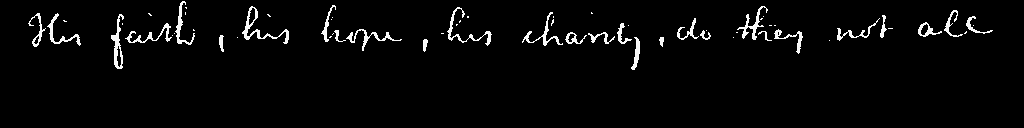

Ground truth: This faith , his hope , his charity , do they not all
Prediction : Hir faith , his hope , his chanty , do they not al 




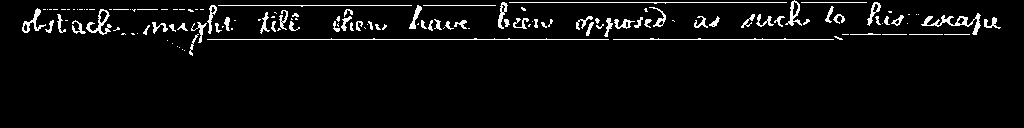

Ground truth: obstacle might till then have been opposed as such to his escape . 
Prediction : obstacle might tell then have bein opposed as such to his ceape 




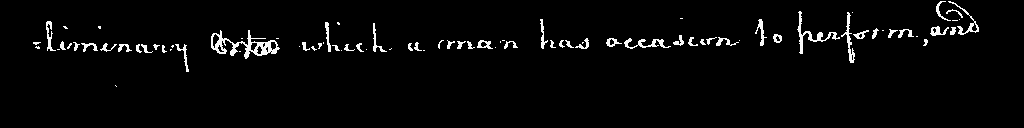

Ground truth: liminary Acts which a man has occasion to perform , and
Prediction : liminary Exterter which a man has occasion to perform , and 




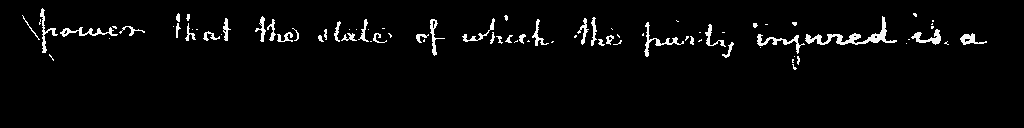

Ground truth: power that the state of which the party injured is a
Prediction : power that the state of which the party ingred is a 




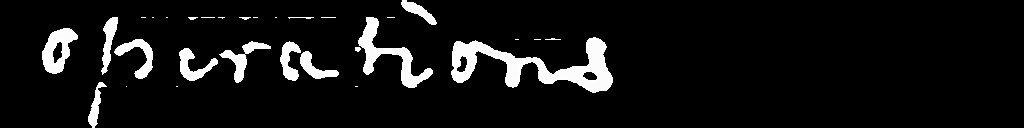

Ground truth: operations
Prediction : ofsera tion 




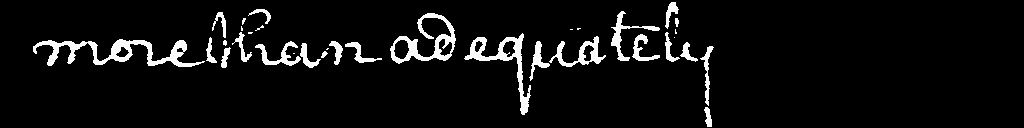

Ground truth: more than adequately
Prediction : morethan adeguately 




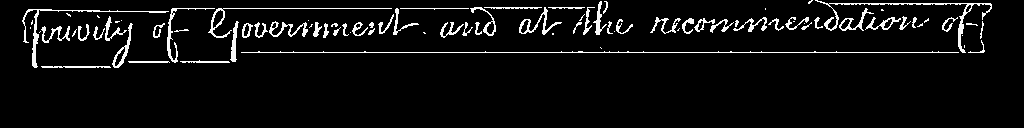

Ground truth: privit of Government and at the recommendation of
Prediction : privity of Government and at the recommendation of 




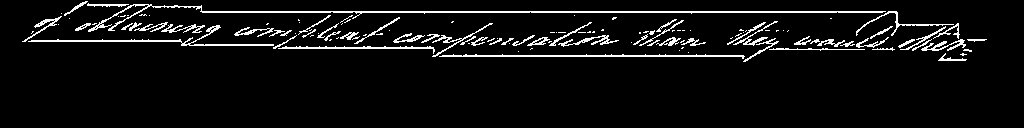

Ground truth: of obtaining compleat compensation than they would other
Prediction : of Lawning comptat componsation they wuld then 




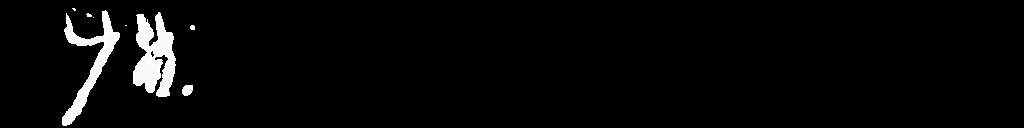

Ground truth: 7 8
Prediction : No .  




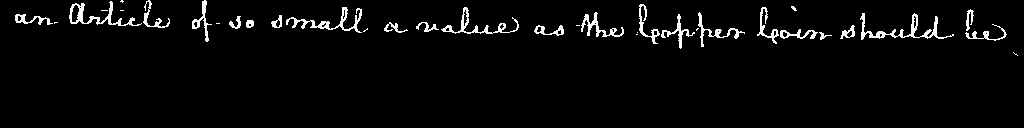

Ground truth: an Article of so small a value as the Copper Coin should be
Prediction : an Article of so small a value as the Copper Coin should be 



In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow
 
for i, item in enumerate(imgs[:10]):
    print("=" * 1024, "\n")
    img = item.permute(1,2,0).cpu().numpy().astype(np.uint8) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    cv2_imshow(pp.adjust_to_see(img))
    print("Ground truth:",gt[i])
    print("Prediction :", predicts[i], "\n")

For the best results I used the ensemble of two checkpoints of model.

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11em8U-TpNgQZwLDGR9B5U3cfV859lSaI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11em8U-TpNgQZwLDGR9B5U3cfV859lSaI" -O resnet_second_best.pt && rm -rf /tmp/cookies.txt

--2020-06-21 12:06:29--  https://docs.google.com/uc?export=download&confirm=N0BG&id=11em8U-TpNgQZwLDGR9B5U3cfV859lSaI
Resolving docs.google.com (docs.google.com)... 173.194.215.113, 173.194.215.138, 173.194.215.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.215.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-3k-docs.googleusercontent.com/docs/securesc/utm5ajtmk5fnl5mh6koat3oci3ts50vv/3ecv7v9firsdkf1hm54b4c7kuje7ff4g/1592741175000/09178631081748859974/06124067857407649856Z/11em8U-TpNgQZwLDGR9B5U3cfV859lSaI?e=download [following]
--2020-06-21 12:06:29--  https://doc-04-3k-docs.googleusercontent.com/docs/securesc/utm5ajtmk5fnl5mh6koat3oci3ts50vv/3ecv7v9firsdkf1hm54b4c7kuje7ff4g/1592741175000/09178631081748859974/06124067857407649856Z/11em8U-TpNgQZwLDGR9B5U3cfV859lSaI?e=download
Resolving doc-04-3k-docs.googleusercontent.com (doc-04-3k-docs.googleusercontent.com)... 74.125.31.132, 2607:f8b0:400c:c02::84
Connect

In [ ]:
second_model = make_model(100) #I used the vocab size of 100
second_model.load_state_dict(torch.load('resnet_second_best.pt'))
_=second_model.to(device)


In [ ]:
beta = 0.5 #The interpolation parameter    
params1 = model.state_dict()
params2 = second_model.state_dict()
 
dict_params2 = params2
 
for name1, param1 in params1.items():
    if name1 in dict_params2:
        dict_params2[name1].data.copy_(beta*param1.data + (1-beta)*dict_params2[name1].data)
 
model.load_state_dict(dict_params2)

<All keys matched successfully>

In [ ]:
predicts, gt, imgs = test(model, test_loader, max_text_length)
 
predicts = list(map(lambda x : x.replace('SOS','').replace('EOS',''),predicts))
gt = list(map(lambda x : x.replace('SOS','').replace('EOS',''),gt))

In [ ]:
evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=gt,)


In [ ]:
print("Calculate Character Error Rate {}, Word Error Rate {} and Sequence Error Rate {}".format(evaluate[0],evaluate[1],evaluate[2]))


Calculate Character Error Rate 0.10120963226356437, Word Error Rate 0.23776842527002964 and Sequence Error Rate 0.757537688442211


In [ ]:
l